First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [66]:
!conda create -n BI2025 python=3.11 -y
!conda activate BI2025
!pip install -r requirements.txt

Jupyter detected...
3 channel Terms of Service accepted
Channels:
 - defaults
Platform: win-64
Solving environment: done

## Package Plan ##

  environment location: C:\Users\johan\anaconda3\envs\BI2025

  added / updated specs:
    - python=3.11


The following NEW packages will be INSTALLED:

  bzip2              pkgs/main/win-64::bzip2-1.0.8-h2bbff1b_6 
  ca-certificates    pkgs/main/win-64::ca-certificates-2025.12.2-haa95532_0 
  expat              pkgs/main/win-64::expat-2.7.3-h885b0b7_4 
  libexpat           pkgs/main/win-64::libexpat-2.7.3-h885b0b7_4 
  libffi             pkgs/main/win-64::libffi-3.4.4-hd77b12b_1 
  libzlib            pkgs/main/win-64::libzlib-1.3.1-h02ab6af_0 
  openssl            pkgs/main/win-64::openssl-3.0.18-h543e019_0 
  pip                pkgs/main/noarch::pip-25.3-pyhc872135_0 
  python             pkgs/main/win-64::python-3.11.14-h981015d_0 
  setuptools         pkgs/main/win-64::setuptools-80.9.0-py311haa95532_0 
  sqlite             pkgs/main/win-64:



==> WARNING: A newer version of conda exists. <==
    current version: 25.5.1
    latest version: 25.11.0

Please update conda by running

    $ conda update -n base -c defaults conda


ERROR conda.core.link:_execute(1029): An error occurred while installing package 'defaults::bzip2-1.0.8-h2bbff1b_6'.

[Errno 13] Permission denied: 'C:\\Users\\johan\\anaconda3\\envs\\BI2025\\Library\\bin\\libbz2.dll'
()


CondaError: Run 'conda init' before 'conda activate'



  Cloning https://github.com/AllStarsAT/starvers.git to c:\users\johan\appdata\local\temp\pip-install-9p3cxo49\starvers_4159e51b824848e7a663399d07337e39
  Resolved https://github.com/AllStarsAT/starvers.git to commit 5e6e112e2b37cb5a27af9585bd572d27187ef735
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/AllStarsAT/starvers.git 'C:\Users\johan\AppData\Local\Temp\pip-install-9p3cxo49\starvers_4159e51b824848e7a663399d07337e39'

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\johan\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [2]:
executed_by = 'stud-id_12019873'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [3]:
# group id for this project
group_id = '43'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12019873'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_76543210'  # Replace the digits after "id_" with student B's student ID

In [4]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [5]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [6]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [7]:
import time
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    time.tzname = ('Europe/Vienna', 'Europe/Vienna')
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] + "Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [10]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
    f':{student_a} rdf:type foaf:Person .',
    f':{student_a} rdf:type prov:Agent .',
    f':{student_a} foaf:givenName "Johanna" .',
    f':{student_a} foaf:familyName "Six" .',
    f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
    f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
    f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
    f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12019873"^^xsd:string .',
]

reigstration_triples_b = [
    f':{student_b} rdf:type foaf:Person .',
    f':{student_b} rdf:type prov:Agent .',
    f':{student_b} foaf:givenName "Bernhard" .',
    f':{student_b} foaf:familyName "Siegl" .',
    f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
    f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
    f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
    f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "76543210"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]

engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

HTTPError: HTTP Error 504: Gateway Time-out

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [ ]:
airline_data_path = os.path.join("data", "airline")

## Business Understanding 

In [60]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
    f':business_understanding_phase rdf:type prov:Activity .',
    f':business_understanding_phase rdfs:label "Business Understanding Phase" .',  ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [29]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
The data source consists of 21 attributes and about 3000 rows. It contains data from December 2019 and 2020, that consists of the number of delayed, cancelled or diverted flights and the cause of delays. The data can be used by airlines to identify what causes the most flight delays / cancellations.
"""

business_objectives_comment = """
The airline wants to improve punctuality and therefore reduce the number of delayed, cancelled flights.
"""

business_success_criteria_comment = """
The success criteria are: improvement of on time performance. Delayed flights are reduced by at least 5 percent in the next year.
Top 10 airports are identified with the most delays, cancelled flights and monitored.
"""

data_mining_goals_comment = """
We need to identify the main drivers of delays and cancellations by analyzing delay causes, airport, airline and temporal factors;
Quantify the distribution of delay categories (weather, carrier, security, NAS, ..);
Identify airports and airlines with significant higher delays/cancellations;
Build models to estimate the likelihood of delays for a given airport, airline and time.
"""

data_mining_success_criteria_comment = """
Clustering results to show interpretable groupings of airports based on their delay and cancellation behaviour,
Achieve a accuraccy of at least 70% with our classification model
"""

ai_risk_aspects_comment = """
The system should be low-risk, as it supports operational analysis and decision-making rather than automated enforcement or individual-level decisions
"""

bu_ass_uuid_executor = "bb6a40f9-9d92-4f9f-bbd2-b65ef6a82da2"  # Generate once
business_understanding_executor = [
    f':business_understanding rdf:type prov:Activity .',
    f':business_understanding sc:isPartOf :business_understanding_phase .',
    # Connect Activity to Parent Business Understanding Phase Activity
    f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
    f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{bu_ass_uuid_executor} rdf:type prov:Association .',
    f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)

business_understanding_data_executor = [
    # 1a
    f':bu_data_source_and_scenario rdf:type prov:Entity .',
    f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
    f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
    f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
    # 1b
    f':bu_business_objectives rdf:type prov:Entity .',
    f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
    f':bu_business_objectives rdfs:label "1b Business Objectives" .',
    f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
    # 1c
    f':bu_business_success_criteria rdf:type prov:Entity .',
    f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
    f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
    f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
    # 1d
    f':bu_data_mining_goals rdf:type prov:Entity .',
    f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
    f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
    f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
    # 1e
    f':bu_data_mining_success_criteria rdf:type prov:Entity .',
    f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
    f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
    f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
    # 1f
    f':bu_ai_risk_aspects rdf:type prov:Entity .',
    f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
    f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
    f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [77]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
    f':data_understanding_phase rdf:type prov:Activity .',
    f':data_understanding_phase rdfs:label "Data Understanding Phase" .',
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [78]:
airline_data_path = os.path.join("data", "airline")
load_airline_data_code_writer = student_a


def load_airline_data() -> pd.DataFrame:
    ### Load your data
    input_file = os.path.join(airline_data_path, 'airline_delay.csv')
    raw_data = pd.read_csv(input_file, sep=',', header=0)

    raw_data.sort_values(['year', 'month'], inplace=True)
    raw_data.set_index(['year', 'month', 'carrier', 'airport'], inplace=True)

    return raw_data


start_time_ld = now()
data = load_airline_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c"  # Generate once
load_airline_data_executor = [
    f':load_airline_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_airline_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210"  # Generate once
ld_report = """
Load all airline data and create a hierarchical index (year, month).
"""
load_airline_data_activity = [
    ':load_airline_data rdf:type prov:Activity .',
    ':load_airline_data sc:isPartOf :data_understanding_phase .',
    ':load_airline_data rdfs:comment \'Data Understanding\' .',
    f':load_airline_data rdfs:comment """{ld_report}""" .',
    f':load_airline_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_airline_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_airline_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_airline_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_airline_data prov:used :raw_data .',
    ':load_airline_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_airline_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_airline_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name \'Airline Delay Dataset (Dec 2019–2020)\' .',
    ':raw_data sc:description \'Summary airline delay counts per carrier per US city for December 2019 and 2020.\' .',

    # Continue with futher information about the dataset...
    ':airline_delay_csv rdf:type cr:FileObject .',
    ':airline_delay_csv sc:name \'airline_delay.csv\' .',
    ':airline_delay_csv sc:encodingFormat \'text/csv\' .',
    ':raw_data sc:distribution :airline_delay .',
    # Continue with further information about the distribution...
    ':raw_recordset rdf:type cr:RecordSet .',
    ':raw_recordset sc:name \'Table of airline data for december for 2019 and 2020\' .',
    ':raw_recordset cr:source :airline_delay_csv .',
    ':raw_data cr:recordSet :raw_recordset .',

    ':raw_recordset cr:field :field_year .',
    ':field_year rdf:type cr:Field .',
    ':field_year sc:name \'year\' .',
    ':field_year sc:description \'Year in which flight data was collected.\' .',
    ':field_year cr:dataType xsd:gYear .',

    ':raw_recordset cr:field :field_month .',
    ':field_month rdf:type cr:Field .',
    ':field_month sc:name \'month\' .',
    ':field_month sc:description \'Month (1–12) of data collection.\' .',
    ':field_month cr:dataType xsd:integer .',
    ':field_month qudt:unit qudt: qudt:DateTimeStringEncodingType  .',

    ':raw_recordset cr:field :field_carrier .',
    ':field_carrier rdf:type cr:Field .',
    ':field_carrier sc:name \'carrier\' .',
    ':field_carrier sc:description \'Two-letter airline carrier code.\' .',
    ':field_carrier cr:dataType xsd:string .',

    ':raw_recordset cr:field :field_carrier_name .',
    ':field_carrier_name rdf:type cr:Field .',
    ':field_carrier_name sc:name \'carrier_name\' .',
    ':field_carrier_name sc:description \'Full airline carrier name.\' .',
    ':field_carrier_name cr:dataType xsd:string .',

    ':raw_recordset cr:field :field_airport .',
    ':field_airport rdf:type cr:Field .',
    ':field_airport sc:name \'airport\' .',
    ':field_airport sc:description \'Three-letter airport code for arrival airport.\' .',
    ':field_airport cr:dataType xsd:string .',

    ':raw_recordset cr:field :field_airport_name .',
    ':field_airport_name rdf:type cr:Field .',
    ':field_airport_name sc:name \'airport_name\' .',
    ':field_airport_name sc:description \'Full name of the airport.\' .',
    ':field_airport_name cr:dataType xsd:string .',

    # Count fields
    ':raw_recordset cr:field :field_arr_flights .',
    ':field_arr_flights rdf:type cr:Field .',
    ':field_arr_flights sc:name \'arr_flights\' .',
    ':field_arr_flights sc:description \'Number of flights arriving at airport.\' .',
    ':field_arr_flights cr:dataType xsd:integer .',
    ':field_arr_flights qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_arr_del15 .',
    ':field_arr_del15 rdf:type cr:Field .',
    ':field_arr_del15 sc:name \'arr_del15\' .',
    ':field_arr_del15 sc:description \'Flights arriving more than 15 minutes late.\' .',
    ':field_arr_del15 cr:dataType xsd:integer .',
    ':field_arr_del15 qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_carrier_ct .',
    ':field_carrier_ct rdf:type cr:Field .',
    ':field_carrier_ct sc:name \'carrier_ct\' .',
    ':field_carrier_ct sc:description \'Flights delayed due to air carrier (e.g. crew).\' .',
    ':field_carrier_ct cr:dataType xsd:integer .',
    ':field_carrier_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_weather_ct .',
    ':field_weather_ct rdf:type cr:Field .',
    ':field_weather_ct sc:name \'weather_ct\' .',
    ':field_weather_ct sc:description \'Flights delayed due to weather.\' .',
    ':field_weather_ct cr:dataType xsd:integer .',
    ':field_weather_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_nas_ct .',
    ':field_nas_ct rdf:type cr:Field .',
    ':field_nas_ct sc:name \'nas_ct\' .',
    ':field_nas_ct sc:description \'Flights delayed due to National Aviation System.\' .',
    ':field_nas_ct cr:dataType xsd:integer .',
    ':field_nas_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_security_ct .',
    ':field_security_ct rdf:type cr:Field .',
    ':field_security_ct sc:name \'security_ct\' .',
    ':field_security_ct sc:description \'Flights canceled due to security issues.\' .',
    ':field_security_ct cr:dataType xsd:integer .',
    ':field_security_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_late_aircraft_ct .',
    ':field_late_aircraft_ct rdf:type cr:Field .',
    ':field_late_aircraft_ct sc:name \'late_aircraft_ct\' .',
    ':field_late_aircraft_ct sc:description \'Flights delayed due to a previous late aircraft.\' .',
    ':field_late_aircraft_ct cr:dataType xsd:integer .',
    ':field_late_aircraft_ct qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_arr_cancelled .',
    ':field_arr_cancelled rdf:type cr:Field .',
    ':field_arr_cancelled sc:name \'arr_cancelled\' .',
    ':field_arr_cancelled sc:description \'Number of cancelled flights.\' .',
    ':field_arr_cancelled cr:dataType xsd:integer .',
    ':field_arr_cancelled qudt:unit qudt:CountingUnit .',

    ':raw_recordset cr:field :field_arr_diverted .',
    ':field_arr_diverted rdf:type cr:Field .',
    ':field_arr_diverted sc:name \'arr_diverted\' .',
    ':field_arr_diverted sc:description \'Number of diverted flights.\' .',
    ':field_arr_diverted cr:dataType xsd:integer .',
    ':field_arr_diverted qudt:unit qudt:CountingUnit .',

    # Delay time (minutes)
    ':raw_recordset cr:field :field_arr_delay .',
    ':field_arr_delay rdf:type cr:Field .',
    ':field_arr_delay sc:name \'arr_delay\' .',
    ':field_arr_delay sc:description \'Total delay time in minutes.\' .',
    ':field_arr_delay cr:dataType xsd:double .',
    ':field_arr_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_carrier_delay .',
    ':field_carrier_delay rdf:type cr:Field .',
    ':field_carrier_delay sc:name \'carrier_delay\' .',
    ':field_carrier_delay sc:description \'Delay minutes due to air carrier issues.\' .',
    ':field_carrier_delay cr:dataType xsd:double .',
    ':field_carrier_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_weather_delay .',
    ':field_weather_delay rdf:type cr:Field .',
    ':field_weather_delay sc:name \'weather_delay\' .',
    ':field_weather_delay sc:description \'Delay minutes due to weather.\' .',
    ':field_weather_delay cr:dataType xsd:double .',
    ':field_weather_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_nas_delay .',
    ':field_nas_delay rdf:type cr:Field .',
    ':field_nas_delay sc:name \'nas_delay\' .',
    ':field_nas_delay sc:description \'Delay minutes due to National Aviation System.\' .',
    ':field_nas_delay cr:dataType xsd:double .',
    ':field_nas_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_security_delay .',
    ':field_security_delay rdf:type cr:Field .',
    ':field_security_delay sc:name \'security_delay\' .',
    ':field_security_delay sc:description \'Delay minutes due to security issues.\' .',
    ':field_security_delay cr:dataType xsd:double .',
    ':field_security_delay qudt:unit qudt:Minute .',

    ':raw_recordset cr:field :field_late_aircraft_delay .',
    ':field_late_aircraft_delay rdf:type cr:Field .',
    ':field_late_aircraft_delay sc:name \'late_aircraft_delay\' .',
    ':field_late_aircraft_delay sc:description \'Delay minutes due to previous late aircraft.\' .',
    ':field_late_aircraft_delay cr:dataType xsd:double .',
    ':field_late_aircraft_delay qudt:unit qudt:Minute .',
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    ':data rdf:type sc:Dataset .',
    # ...
    ':recordset rdf:type cr:RecordSet .',
    # ...
    ':data cr:recordSet :recordset .',
    # ...
    # Fields can also be reused
    ':recordset cr:field :field_date .',
    ':recordset cr:field :field_number .',
    # The loaded data has additional fields
    ':recordset cr:field :field_day_of_week .',
    ':field_day_of_week rdf:type cr:Field .',
    ':field_day_of_week sc:name \'day_of_week\' .',
    ':field_day_of_week sc:description \'Day of week description\' .',
    ':field_day_of_week cr:dataType xsd:string .',
    # This is not actually a field in the dataframe but below demonstrates how units may be used
    ':recordset cr:field :field_temp .',
    ':field_temp rdf:type cr:Field .',
    ':field_temp sc:name \'temperature\' .',
    ':field_temp sc:description \'Description Temperature\' .',
    ':field_temp cr:dataType xsd:double .',
]
engine.insert(data_triples, prefixes=prefixes)

# Also add the units to the fields
units_triples = [
    ':field_number qudt:unit qudt:CountingUnit .',
    ':field_temp qudt:unit siu:degree_Celsius .',

    ':field_year qudt:unit qudt: qudt:DateTimeStringEncodingType  .',

]
engine.insert(units_triples, prefixes=prefixes)

carrier_name  \
year month carrier airport                            
2019 12    EV      BDL      ExpressJet Airlines LLC   
                   BGR      ExpressJet Airlines LLC   
                   BHM      ExpressJet Airlines LLC   
                   BNA      ExpressJet Airlines LLC   
                   BRO      ExpressJet Airlines LLC   

                                                                             airport_name  \
year month carrier airport                                                                  
2019 12    EV      BDL                                Hartford, CT: Bradley International   
                   BGR                                   Bangor, ME: Bangor International   
                   BHM             Birmingham, AL: Birmingham-Shuttlesworth International   
                   BNA                             Nashville, TN: Nashville International   
                   BRO      Brownsville, TX: Brownsville South Padre Island International   

                            arr_flights  arr_del15  carrier_ct  weather_ct  \
year month carrier airport                                                   
2019 12    EV      BDL             14.0        4.0        2.00        0.00   
                   BGR             34.0       16.0        4.12        0.00   
                   BHM             65.0       13.0        4.52        0.04   
                   BNA            120.0       41.0       11.01        0.74   
                   BRO             96.0       17.0        8.01        0.00   

                            nas_ct  security_ct  late_aircraft_ct  \
year month carrier airport                                          
2019 12    EV      BDL        0.00          0.0              2.00   
                   BGR        3.90          0.0              7.98   
                   BHM        5.96          0.0              2.48   
                   BNA       13.99          0.0             15.25   
                   BRO        4.66          0.0              4.33   

                            arr_cancelled  arr_diverted  arr_delay  \
year month carrier airport                                           
2019 12    EV      BDL                0.0           0.0      114.0   
                   BGR                2.0           0.0     1450.0   
                   BHM                0.0           0.0      572.0   
                   BNA                6.0           0.0     2638.0   
                   BRO                1.0           0.0     1037.0   

                            carrier_delay  weather_delay  nas_delay  \
year month carrier airport                                            
2019 12    EV      BDL               61.0            0.0        0.0   
                   BGR              682.0            0.0      231.0   
                   BHM              233.0            2.0      206.0   
                   BNA              670.0          164.0      685.0   
                   BRO              578.0            0.0      139.0   

                            security_delay  late_aircraft_delay  
year month carrier airport                                       
2019 12    EV      BDL                 0.0                 53.0  
                   BGR                 0.0                537.0  
                   BHM                 0.0                131.0  
                   BNA                 0.0               1119.0  
                   BRO                 0.0                320.0

QueryBadFormed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'MALFORMED QUERY: number of values in bindingset does not match variables in BINDINGS clause'

In [26]:
numeric_stats = data.describe().T
print(numeric_stats)

                      count         mean           std  min     25%     50%  \
arr_flights          3343.0   298.271014    852.436335  1.0   35.00   83.00   
arr_del15            3343.0    50.995214    146.484456  0.0    5.00   12.00   
carrier_ct           3343.0    16.065337     41.759516  0.0    1.49    4.75   
weather_ct           3343.0     1.443144      4.821657  0.0    0.00    0.06   
nas_ct               3343.0    16.183383     56.423008  0.0    0.82    2.98   
security_ct          3343.0     0.137320      0.646479  0.0    0.00    0.00   
late_aircraft_ct     3343.0    17.166069     55.447043  0.0    0.90    3.28   
arr_cancelled        3343.0     2.884535     10.126658  0.0    0.00    0.00   
arr_diverted         3343.0     0.575830      2.097884  0.0    0.00    0.00   
arr_delay            3343.0  3333.868083  10284.926623  0.0  230.00  746.00   
carrier_delay        3343.0  1144.763087   3371.103512  0.0   68.50  272.00   
weather_delay        3343.0   177.591385    734.3435

In [92]:
#check missing values
missing = {
    col: data.index[data[col].isna()].tolist()
    for col in data.columns
    if data[col].isna().any()
}
for col, count in missing.items():
    print(f"{col}: {count}")


arr_flights: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
arr_del15: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
carrier_ct: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
weather_ct: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO', 'PWM'), (2020, 12, 'UA', 'PNS'), (2020, 12, 'UA', 'STL')]
nas_ct: [(2019, 12, 'OO', 'MLB'), (2020, 12, 'DL', 'BIL'), (2020, 12, 'DL', 'CHA'), (2020, 12, 'DL', 'FAI'), (2020, 12, 'OO', 'BDL'), (2020, 12, 'OO

In [98]:
def check_skewness(df: pd.DataFrame, column: str):
    s = df[column].dropna()
    sk = s.skew()
    print(f"Skewness of '{column}': {sk:.3f}")
    return sk

numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]
for col in numeric_cols:
    check_skewness(data, col)


Skewness of 'arr_flights': 8.691
Skewness of 'arr_del15': 6.861
Skewness of 'carrier_ct': 7.167
Skewness of 'weather_ct': 9.358
Skewness of 'nas_ct': 8.779
Skewness of 'security_ct': 10.734
Skewness of 'late_aircraft_ct': 7.374
Skewness of 'arr_cancelled': 9.230
Skewness of 'arr_diverted': 10.504
Skewness of 'arr_delay': 7.452
Skewness of 'carrier_delay': 7.994
Skewness of 'weather_delay': 10.293
Skewness of 'nas_delay': 12.494
Skewness of 'security_delay': 10.008
Skewness of 'late_aircraft_delay': 7.842


In [100]:
#check correlation
numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]
flight_corr = data[numeric_cols].corr()
print(flight_corr)

                     arr_flights  arr_del15  carrier_ct  weather_ct    nas_ct  \
arr_flights             1.000000   0.928553    0.913941    0.728294  0.821692   
arr_del15               0.928553   1.000000    0.925558    0.697453  0.912643   
carrier_ct              0.913941   0.925558    1.000000    0.687277  0.741848   
weather_ct              0.728294   0.697453    0.687277    1.000000  0.598149   
nas_ct                  0.821692   0.912643    0.741848    0.598149  1.000000   
security_ct             0.525694   0.529340    0.550511    0.329421  0.423072   
late_aircraft_ct        0.859181   0.949273    0.870981    0.625493  0.777828   
arr_cancelled           0.602233   0.671842    0.585325    0.503454  0.619514   
arr_diverted            0.502627   0.553319    0.466475    0.463821  0.540636   
arr_delay               0.856262   0.960250    0.851834    0.731967  0.901357   
carrier_delay           0.887762   0.908416    0.919436    0.769016  0.775503   
weather_delay           0.58

In [101]:
#check kurtosis
kurtosis = data.kurtosis(numeric_only=True)

print("\nKurtosis:\n", kurtosis)


Kurtosis:
 arr_flights            123.744088
arr_del15               61.438774
carrier_ct              73.625446
weather_ct             115.695268
nas_ct                 104.171473
security_ct            191.295280
late_aircraft_ct        68.782659
arr_cancelled          125.291689
arr_diverted           154.613759
arr_delay               72.225550
carrier_delay           87.983583
weather_delay          136.121660
nas_delay              223.086411
security_delay         137.612808
late_aircraft_delay     81.848748
dtype: float64


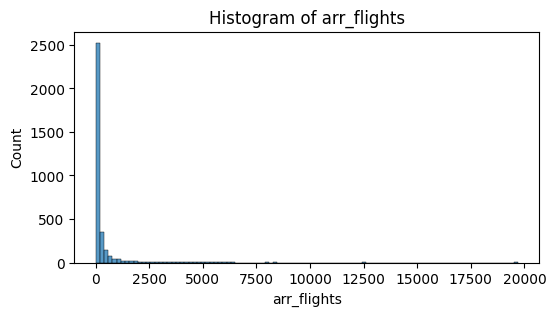

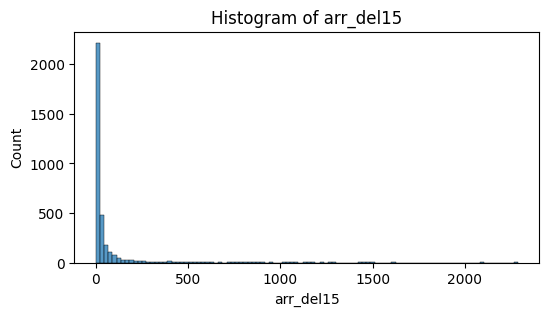

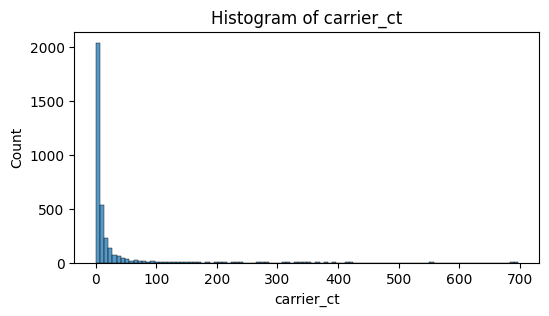

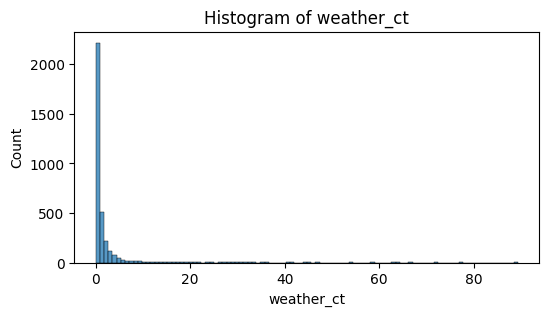

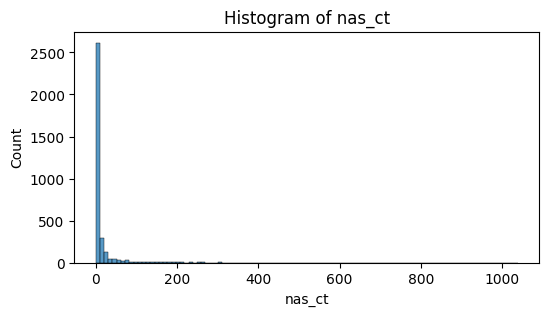

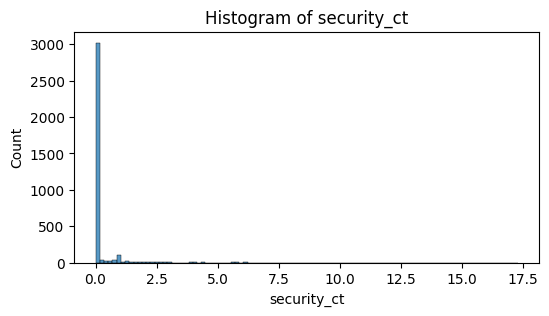

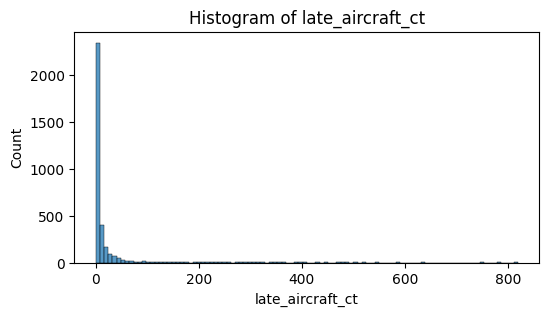

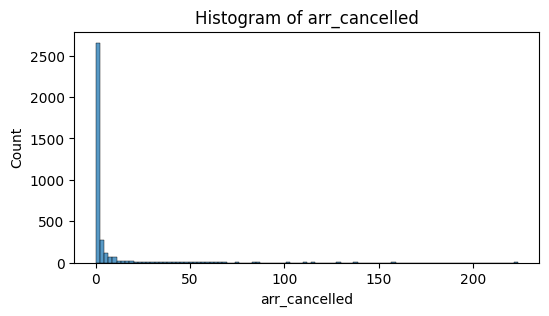

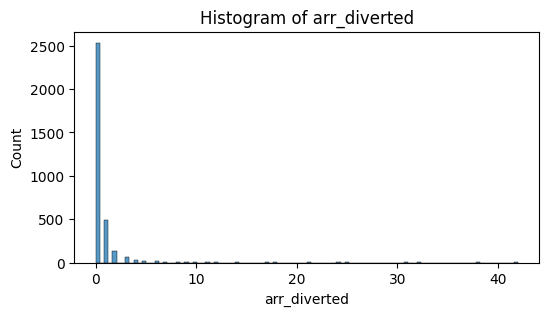

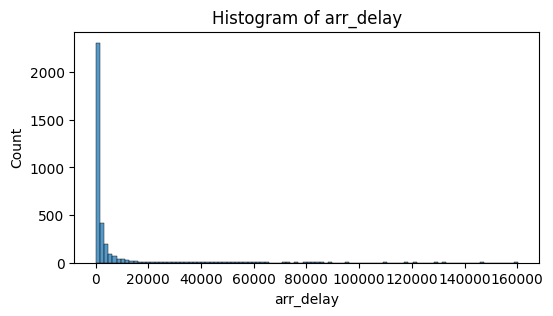

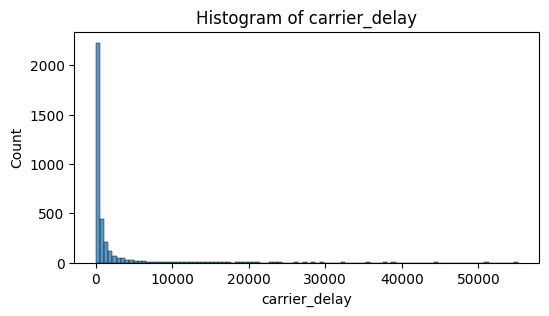

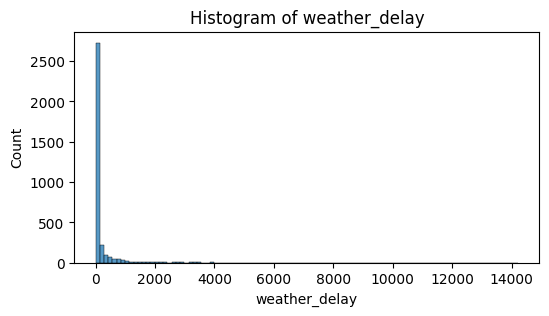

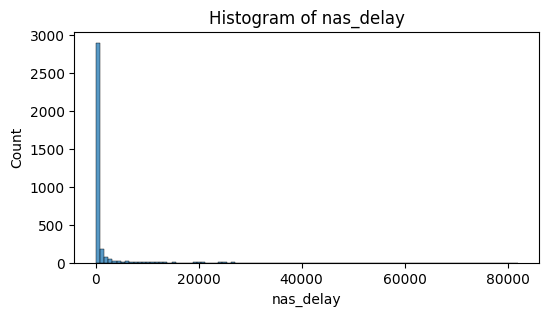

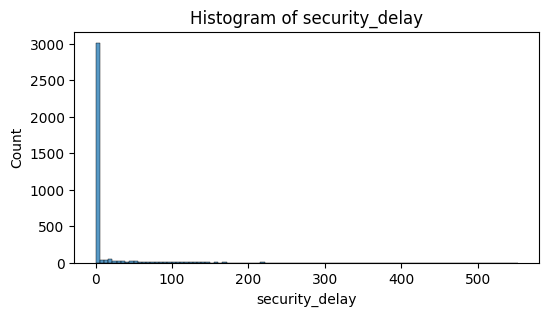

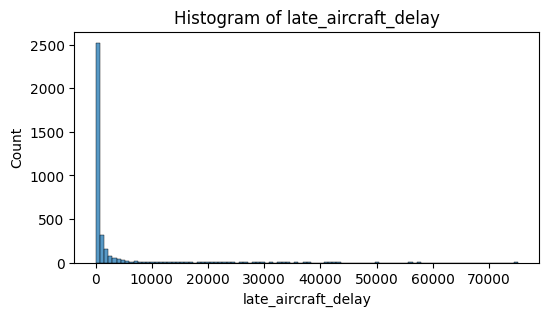

In [104]:
#visualize histogram
import seaborn

numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]

for col in numeric_cols:
    plt.figure(figsize=(6,3))
    seaborn.histplot(data[col], bins=100, kde=False)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

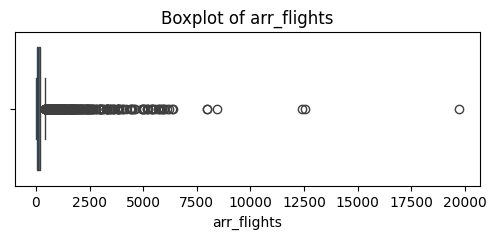

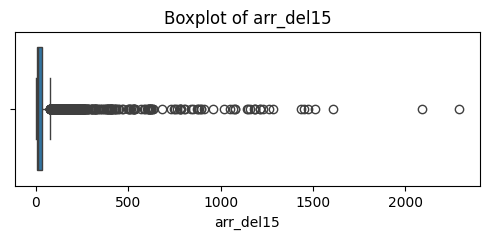

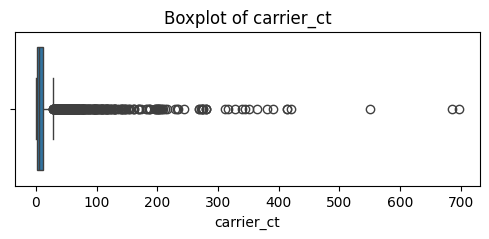

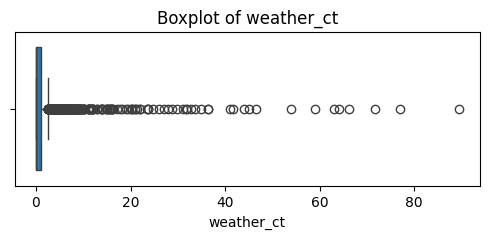

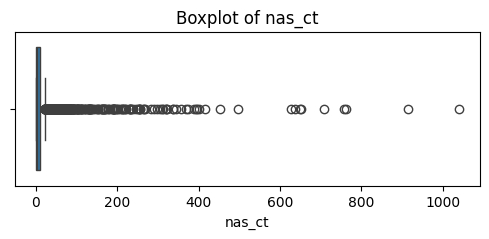

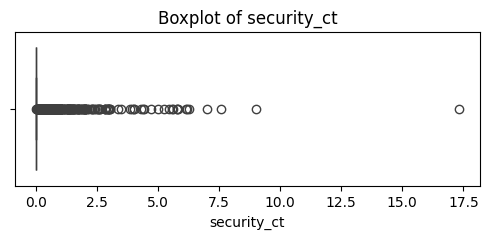

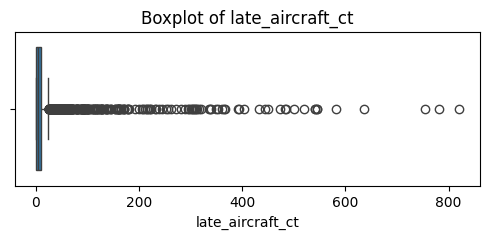

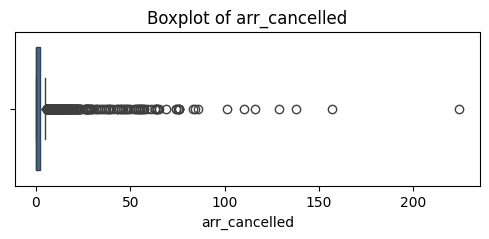

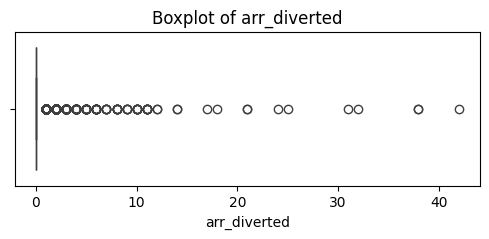

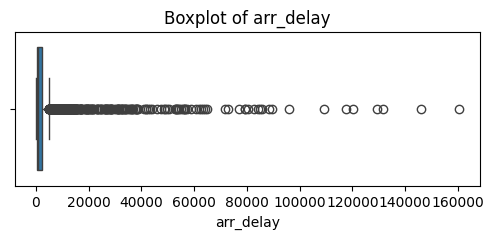

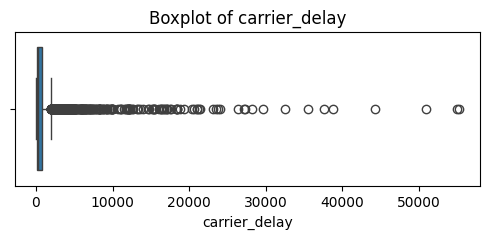

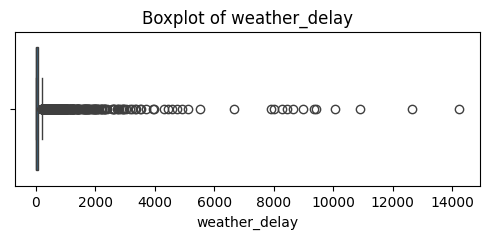

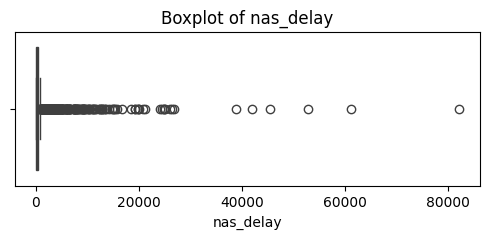

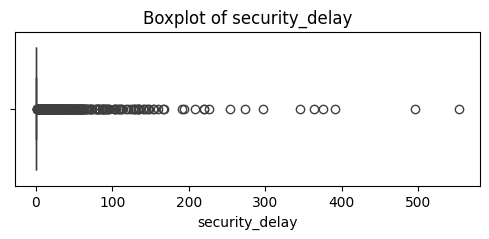

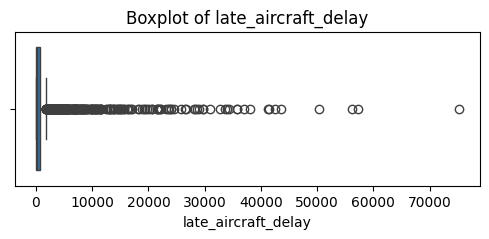

In [105]:
#visualize outliers
numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]

for col in numeric_cols:
    plt.figure(figsize=(6,2))
    seaborn.boxplot(x=data[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [119]:
check_outliers_code_writer = student_a


def check_outliers(data: pd.DataFrame, threshold=3.0, columns='arr_flights') -> dict:
    results = {}

    ### DIRTY HACK
    ### REPLACE WITH YOUR ACTUAL OUTLIER CHECKING

    tmp = data.copy()
    tmp = tmp.reset_index(drop=True)

    for col in columns:
        values = tmp[col].astype(float)

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std

        mask = np.abs(z_scores) > threshold
        outliers = values[mask].index

        outlier_info = [
            {
                'index': int(idx),
                'z_score': float(z_scores.loc[idx])
            }
            for idx in outliers
        ]

        results[col] = outlier_info

    return results


start_time_co = now()
outlier_columns = list(data.columns[2::])
outliers_report = check_outliers(data, outlier_columns)
print(outliers_report)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()

#############################################
# Documentation
#############################################
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => in this case a report
# 2. activity inspects the outcome and derives decisions => in this case to remove the outliers that were found
# 3. activity follows up on the decision by changing the data => will be done in the data preparation phase

# 1. Activty: Checking for outliers and creating the report
co_ass_uuid_executor = "15085e9d-15f1-4727-9b6e-776dd07fcd08"
check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)

co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"
co_comment = """
Identifying outliers with a dirty hack that uses the z-score of each row within in column and reports all values
with a z-score higher than 2.2 as an outlier, which is not a reasonable threshold but used here to avoid not
finding any outliers for demonstration purposes.
"""
check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment \'Data Understanding\' .',
    f':check_outliers rdfs:comment """{co_comment}""" .',
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
    # ...
]
engine.insert(check_outliers_activity, prefixes=prefixes)

# 2. Activity: Inspecting the report and taking a decision on what to do
ior_ass_uuid_executor = "6eaa2c0a-e592-4d85-b37f-d695844910cf"
ior_comment = """
After inspecting the report the decision has been made to remove all outliers that were identfied for demonstration purpose3
"""
inspect_outlier_report_executor = student_a
inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment \'Data Understanding\' .',
    f':inspect_outlier_report rdfs:comment """{co_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    f':outlier_decision rdfs:comment """Removing all outliers for demonstration purposes.""" .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
    # ...
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

KeyError: 'a'

In [111]:
numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
                'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                'security_delay', 'late_aircraft_delay']


#check for negative values
for col in numeric_cols:
    if (data[col] < 0).any():
        print(f"Column {col} has negative values!")

#check for invalid values
invalid_del15 = data[data['arr_del15'] > data['arr_flights']]
print("Rows with arr_del15 > arr_flights:", len(invalid_del15))

invalid_cancel = data[data['arr_cancelled'] > data['arr_flights']]
print("Rows with arr_cancelled > arr_flights:", len(invalid_cancel))

#check for outliers
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)]
    print(f"{col}: {len(outliers)} outliers")


Rows with arr_del15 > arr_flights: 0
Rows with arr_cancelled > arr_flights: 0
arr_flights: 432 outliers
arr_del15: 434 outliers
carrier_ct: 397 outliers
weather_ct: 426 outliers
nas_ct: 430 outliers
security_ct: 361 outliers
late_aircraft_ct: 433 outliers
arr_cancelled: 348 outliers
arr_diverted: 807 outliers
arr_delay: 414 outliers
carrier_delay: 401 outliers
weather_delay: 489 outliers
nas_delay: 413 outliers
security_delay: 361 outliers
late_aircraft_delay: 435 outliers


**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

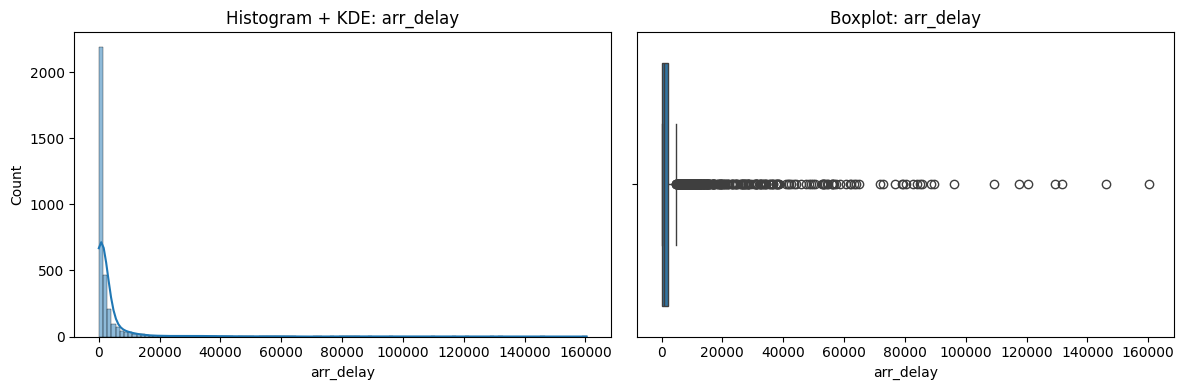

In [113]:
def check_distribution(df: pd.DataFrame, column: str):
    s = df[column].dropna()

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    seaborn.histplot(s, kde=True, ax=axes[0])
    axes[0].set_title(f"Histogram + KDE: {column}")

    seaborn.boxplot(x=s, ax=axes[1])
    axes[1].set_title(f"Boxplot: {column}")

    plt.tight_layout()
    plt.show()

check_distribution(data, "arr_delay")

In [121]:
def iqr_outliers(df: pd.DataFrame, columns, multiplier=1.5):
    results = {}

    for col in columns:
        col_values = df[col].astype(float)
        Q1 = col_values.quantile(0.25)
        Q3 = col_values.quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        mask = (col_values < lower_bound) | (col_values > upper_bound)
        outlier_indices = col_values[mask].index

        outlier_info = []
        for idx in outlier_indices:
            value = float(col_values.loc[idx])
            if IQR == 0:
                iqr_dist = np.nan  # cannot compute distance
            else:
                iqr_dist = float((value - Q3) / IQR) if value > Q3 else float((Q1 - value) / IQR)

            outlier_info.append({
                'index': idx,
                'value': value,
                'iqr_distance': iqr_dist
            })

        results[col] = outlier_info

    return results

numeric_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct',
                'arr_cancelled', 'arr_diverted', 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                'security_delay', 'late_aircraft_delay']
outliers = iqr_outliers(data, numeric_cols)
print(outliers)

{'arr_flights': [{'index': (2019, 12, 'EV', 'EWR'), 'value': 1424.0, 'iqr_distance': 7.70846394984326}, {'index': (2019, 12, 'EV', 'IAH'), 'value': 2638.0, 'iqr_distance': 15.31974921630094}, {'index': (2019, 12, 'EV', 'ORD'), 'value': 1336.0, 'iqr_distance': 7.156739811912225}, {'index': (2019, 12, 'F9', 'DEN'), 'value': 1666.0, 'iqr_distance': 9.225705329153605}, {'index': (2019, 12, 'F9', 'LAS'), 'value': 1044.0, 'iqr_distance': 5.326018808777429}, {'index': (2019, 12, 'F9', 'MCO'), 'value': 1411.0, 'iqr_distance': 7.6269592476489025}, {'index': (2019, 12, 'F9', 'PHL'), 'value': 529.0, 'iqr_distance': 2.09717868338558}, {'index': (2019, 12, 'F9', 'RSW'), 'value': 471.0, 'iqr_distance': 1.7335423197492164}, {'index': (2019, 12, 'F9', 'TPA'), 'value': 453.0, 'iqr_distance': 1.6206896551724137}, {'index': (2019, 12, 'G4', 'AZA'), 'value': 543.0, 'iqr_distance': 2.1849529780564265}, {'index': (2019, 12, 'G4', 'LAS'), 'value': 830.0, 'iqr_distance': 3.9843260188087775}, {'index': (2019, 

## Data Preparation

In [65]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
    f':data_preparation_phase rdf:type prov:Activity .',
    f':data_preparation_phase rdfs:label "Data Preparation Phase" .',
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [66]:
handle_outliers_code_writer = student_b


def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    # REMOVE OUTLIERS
    return df


start_time_td = now()
handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "ec7e81e1-86ea-475a-a8d4-c7d8ee535488"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "1405f15a-3545-4014-a962-637f3c10a137"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .',
    f':handle_outliers rdfs:comment """{td_comment}""" .',
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [67]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # ....
]
engine.insert(prepared_data_triples, prefixes=prefixes)

## Modeling

In [68]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
    f':modeling_phase rdf:type prov:Activity .',
    f':modeling rdfs:label "Modeling Phase" .',
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [69]:
model_data_code_writer = student_a

#############################################
# Documentation 4a
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
dma_comment = """
...
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # example algorithm definition
    f':random_forest_algorithm rdf:type mls:Algorithm .',
    f':random_forest_algorithm rdfs:label "Random Forest Algorithm" .',

    # example implementation
    f':random_forrest_classifier_implementation rdf:type mls:Implementation .',
    f':random_forrest_classifier_implementation rdfs:label "Scikit-learn RandomForestClassifier" .',
    f':random_forrest_classifier_implementation mls:implements :random_forest_algorithm .',
    f':random_forrest_classifier_implementation prov:wasGeneratedBy :define_algorithm .',

    # you can also define your Evaluation Measures here

    # example evaluation 
    f':r2_score_measure rdf:type mls:EvaluationMeasure .',
    f':r2_score_measure rdfs:label "R-squared Score" .',
    f':r2_score_measure rdfs:comment "xxx" .',
    f':r2_score_measure prov:wasGeneratedBy :define_algorithm .',

]
engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [70]:
#############################################
# Documentation 4b
#############################################

hp_ass_uuid_writer = "fff582a8-c5cd-4030-978b-9f56b603167c"
hp_comment = """
...
"""
identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    # example parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate" .',
    f':hp_learning_rate rdfs:comment "..." .',
    f':random_forrest_classifier_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # continue with your identified hyperparameters

]
engine.insert(identify_hp_activity, prefixes=prefixes)

In [71]:
def split_data(df: pd.DataFrame):
    #do something
    return 'train_set', 'validation_set', 'test_set'


#############################################
# Documentation 4c
#############################################

### Define Train/Validation/Test splits
split_ass_uuid_writer = "fb58ae6c-9d58-44c9-ac7e-529111bdf7fc"
split_comment = """
...
"""
## Use your prepared dataset
input_dataset = ":prepared_data"

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',

    # Training Set
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains xx samples" .',

    # Validation Set
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains xx samples" .',

    # Test Set
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains xx samples" .',

]
engine.insert(define_split_activity, prefixes=prefixes)

In [72]:
def train_and_finetune_model(training_set, validation_set):
    # do something here

    # Try to automate as much documentation work as possible.
    # Define your training runs with their respective hyperparameter settings, etc.
    # Document each time a training run, model, its hp_settings, evaluations, ...  
    # Create performance figures/graphs

    return 'Find most suitable model'


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now()

#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "21d60fe3-c9ab-4a0a-bae7-b9fe9653c755"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1"
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"

train_model_activity = [
    # Activity 
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',

    ########################################
    # ONE model run - automate everything below!

    # Parameter settings
    f':{hp1_setting_run1} rdf:type mls:HyperParameterSetting .',
    f':{hp1_setting_run1} mls:specifiedBy :hp_learning_rate .',
    f':{hp1_setting_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{hp1_setting_run1} prov:wasGeneratedBy :train_and_finetune_model .',
    # add your further parameters

    # Describe your Run
    f':{training_run1} rdf:type mls:Run .',
    f':{training_run1} sc:isPartOf :train_and_finetune_model .',
    f':{training_run1} mls:realizes :random_forest_algorithm .',
    f':{training_run1} rdf:label "Training Run 1 with..." .',
    f':{training_run1} mls:executes :your_implementation .',
    f':{training_run1} mls:hasInput :training_set .',
    f':{training_run1} mls:hasInput :validation_set .',
    f':{training_run1} mls:hasInput :{hp1_setting_run1} .',
    # list all your used parameters here
    f':{training_run1} mls:hasOutput :{model_run1} .',
    f':{training_run1} mls:hasOutput :{eval_train_run1} .',
    f':{training_run1} mls:hasOutput :{eval_validation_run1} .',

    # Describe your Model
    f':{model_run1} rdf:type mls:Model .',
    f':{model_run1} prov:label "xxx" .',
    f':{model_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{model_run1} mlso:trainedOn :training_set .',
    f':{model_run1} mlso:hasAlgorithmType :random_forest_algorithm .',

    # Describe your evaluations
    # You can have multiple evaluations per model 
    f':{eval_train_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_train_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_train_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_train_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_train_run1} prov:used :training_set .',

    f':{eval_validation_run1} rdf:type mls:ModelEvaluation .',
    f':{eval_validation_run1} prov:wasGeneratedBy :{training_run1} .',
    f':{eval_validation_run1} mls:hasValue "1.23"^^xsd:double .',
    f':{eval_validation_run1} mls:specifiedBy :r2_score_measure .',
    f':{eval_validation_run1} prov:used :validation_set .',

    # Dont forget to document any visualizations

]
engine.insert(train_model_activity, prefixes=prefixes)


In [73]:
def retrain_model_full_data(training_set, validation_set):
    # create your
    return "Final Trained Model"


start_time_tafm = now()
# train_and_finetune_model()
end_time_tafm = now()

#############################################
# Documentation 4g
#############################################

retrain_ass_uuid_writer = "96815ee0-524c-437b-b5fa-2e15b945c993"  # Generate once

final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Document the retraining activity.
# Hint: This activity is still part of the :modeling_phase

retrain_documentation = [
    # your documentation here    
]
engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [74]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
    f':evaluation_phase rdf:type prov:Activity .',
    f':evaluation_phase rdfs:label "Evaluation Phase" .',
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

In [75]:
eval_code_writer = student_b


def evaluate_on_test_data(final_model, test_set):
    # Predict and evaluation on test data

    return 'Performance'


start_time_eval = now()
#evaluate_on_test_data()
end_time_eval = now()

#############################################
# Documentation
#############################################

eval_ass_uuid = "7f1431e9-feed-429a-92ed-c131b23cbe79"  # Generate once
final_model = ":final_model_entity"
test_set = ":test_set"

eval_comment = """
...
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation on Test Set" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',

    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',

    # Inputs
    f':evaluate_final_model prov:used {final_model} .',
    f':evaluate_final_model prov:used {test_set} .',

    # Reference to Data Mining Success Criteria from Phase 1
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',

    # Document you final model performance

    # Hint: you evaluate bias in this way:
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result prov:wasGeneratedBy :evaluate_final_model .',
    f':bias_evaluation_result rdfs:label "Bias Analysis" .',
    f':bias_evaluation_result rdfs:comment "..." .',

]
engine.insert(evaluate_activity, prefixes=prefixes)

## Deployment

In [76]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
    f':deployment_phase rdf:type prov:Activity .',
    f':deployment_phase rdfs:label "Deployment Phase" .',
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [77]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "72a921e0-1234-4567-89ab-cdef01234567"  # Generate once
deployment_executor = [
    f':plan_deployment rdf:type prov:Activity .',
    f':plan_deployment sc:isPartOf :deployment_phase .',  # Connect to Parent Phase
    f':plan_deployment rdfs:label "Plan Deployment"@en .',

    f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
    f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dep_ass_uuid_executor} rdf:type prov:Association .',
    f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(deployment_executor, prefixes=prefixes)

deployment_data_executor = [
    #6a
    f':dep_recommendations rdf:type prov:Entity .',
    f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
    f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
    f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
    #6b
    f':dep_ethical_risks rdf:type prov:Entity .',
    f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
    f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
    f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
    #6c
    f':dep_monitoring_plan rdf:type prov:Entity .',
    f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
    f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
    f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
    #6d
    f':dep_reproducibility_reflection rdf:type prov:Entity .',
    f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
    f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
    f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [30]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/"

In [31]:
# This cell includes cleaning functions

from datetime import datetime


def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"),
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"),
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text


def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')

    return s


def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [32]:
# This cell includes exemplary queries for different phases


### Author Block
author_query = f"""
{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>

SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  
  ?uri a foaf:Person .
  ?uri foaf:givenName ?given .
  ?uri foaf:familyName ?family .
  ?uri iao:IAO_0000219 ?matr .
}}
"""

res_authors = engine.query(author_query)
author_block_latex = ""

if not res_authors.empty:  # type:ignore
    for _, row in res_authors.iterrows():  # type:ignore

        uri_str = str(row['uri'])
        given = latex_escape(clean_rdf(row['given']))
        family = latex_escape(clean_rdf(row['family']))
        matr = latex_escape(clean_rdf(row['matr']))
        if student_a in uri_str:
            responsibility = "Student A"
        elif student_b in uri_str:
            responsibility = "Student B"
        else:
            responsibility = "Student"

        author_block_latex += rf"""
          \author{{{given} {family}}}
          \authornote{{{responsibility}, Matr.Nr.: {matr}}}
          \affiliation{{
            \institution{{TU Wien}}
            \country{{Austria}}
          }}
          """

### Business Understanding example
bu_query = f"""
{prefix_header}

SELECT ?ds_comment ?bo_comment WHERE {{
  OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }}
  OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }}
}} LIMIT 1
"""
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {}  # type:ignore
bu_data_source = latex_escape(clean_rdf(row_bu.get("ds_comment", "")))
bu_objectives = latex_escape(clean_rdf(row_bu.get("bo_comment", "")))

### Data Understanding examples
# Example Dataset Description
du_desc_query = f"""
{prefix_header}
SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1
"""
res_du_desc = engine.query(du_desc_query)
row_du_desc = res_du_desc.iloc[0] if not res_du_desc.empty else {}  # type:ignore
du_description = latex_escape(clean_rdf(row_du_desc.get("desc", "")))

# Example Feature Columns Table
du_query = f"""
{prefix_header}

SELECT ?name (SAMPLE(?dtypeRaw) as ?dtype) (SAMPLE(?descRaw) as ?desc) WHERE {{
  :raw_data cr:recordSet ?rs .
  ?rs cr:field ?field .
  ?field sc:name ?name .
  ?field sc:description ?descRaw .
  ?field cr:dataType ?dtypeRaw .
}} 
GROUP BY ?name
ORDER BY ?name
"""
res_du = engine.query(du_query)
du_rows = []
if not res_du.empty:  # type:ignore
    for _, f in res_du.iterrows():  # type:ignore
        dtype_raw = clean_rdf(f.get("dtype", ""))
        if '#' in dtype_raw:
            dtype = dtype_raw.split('#')[-1]
        elif '/' in dtype_raw:
            dtype = dtype_raw.split('/')[-1]
        else:
            dtype = dtype_raw

        desc = clean_rdf(f.get("desc", ""))
        row_str = f"{latex_escape(clean_rdf(f['name']))} & {latex_escape(dtype)} & {latex_escape(desc)} \\\\"
        du_rows.append(row_str)
du_table_rows = "\n    ".join(du_rows)

### Modeling example
# Hyperparameters
hp_query = f"""
{prefix_header}

SELECT ?hpName (SAMPLE(?hpValRaw) as ?hpVal) (MAX(?hpDescRaw) as ?hpDesc) WHERE {{
  ?run sc:isPartOf :train_and_finetune_model .
  ?run mls:hasInput ?setting .
  ?setting a mls:HyperParameterSetting .
  ?setting mls:hasValue ?hpValRaw .
  ?setting mls:specifiedBy ?hpDef .
  ?hpDef rdfs:label ?hpName .
  OPTIONAL {{ ?hpDef rdfs:comment ?hpDescRaw . }}
}} 
GROUP BY ?hpName
ORDER BY ?hpName
"""
res_hp = engine.query(hp_query)
hp_rows = []
if not res_hp.empty:  #type:ignore
    for _, row in res_hp.iterrows():  #type:ignore
        name = latex_escape(clean_rdf(row['hpName']))
        val = latex_escape(clean_rdf(row['hpVal']))
        desc = latex_escape(clean_rdf(row.get('hpDesc', '')))
        hp_rows.append(rf"{name} & {desc} & {val} \\")

hp_table_rows = "\n    ".join(hp_rows)

# Run Info
run_query = f"""
{prefix_header}

SELECT ?algoLabel ?start ?end ?metricLabel ?metricVal WHERE {{
  OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }}
  OPTIONAL {{
      ?run sc:isPartOf :train_and_finetune_model .
      ?run mls:realizes ?algo .
      ?algo rdfs:label ?algoLabel .
  }}
  OPTIONAL {{
    ?run sc:isPartOf :train_and_finetune_model .
    ?run mls:hasOutput ?eval .
    ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal .
    OPTIONAL {{ ?eval mls:specifiedBy ?m . ?m rdfs:label ?metricLabel . }}
  }}
}} LIMIT 1
"""
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {}  #type:ignore
mod_algo = latex_escape(clean_rdf(row_run.get("algoLabel", "")))
mod_start = latex_escape(fmt_iso(clean_rdf(row_run.get("start"))))
mod_end = latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_lbl = latex_escape(clean_rdf(row_run.get("metricLabel", "")))
raw_val = clean_rdf(row_run.get('metricVal', ''))
mod_m_val = f"{float(raw_val):.4f}" if raw_val else ""

print("Data extraction done.")

Data extraction done.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [34]:
latex_content = rf"""\documentclass[sigconf]{{acmart}}

\AtBeginDocument{{ \providecommand\BibTeX{{ Bib\TeX }} }}
\setcopyright{{acmlicensed}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmDOI{{XXXXXXX.XXXXXXX}}

\acmConference[BI 2025]{{Business Intelligence}}{{-}}{{-}}

\begin{{document}}

\title{{BI2025 Experiment Report - Group {group_id}}}
%% ---Authors: Dynamically added ---
{author_block_latex}

\begin{{abstract}}
  This report documents the machine learning experiment for Group {group_id}, following the CRISP-DM process model.
\end{{abstract}}

\ccsdesc[500]{{Computing methodologies~Machine learning}}
\keywords{{CRISP-DM, Provenance, Knowledge Graph, Machine Learning}}

\maketitle

%% --- 1. Business Understanding ---
\section{{Business Understanding}}

\subsection{{Data Source and Scenario}}
{bu_data_source}

\subsection{{Business Objectives}}
{bu_objectives}

%% --- 2. Data Understanding ---
\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

The following features were identified in the dataset:

\begin{{table}}[h]
  \caption{{Raw Data Features}}
  \label{{tab:features}}
  \begin{{tabular}}{{lp{{0.2\linewidth}}p{{0.4\linewidth}}}}
    \toprule
    \textbf{{Feature Name}} & \textbf{{Data Type}} & \textbf{{Description}} \\
    \midrule
    {du_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

%% --- 3. Data Preparation ---
\section{{Data Preparation}}
\subsection{{Data Cleaning}}
Describe your Data preparation steps here and include respective graph data.


%% --- 4. Modeling ---
\section{{Modeling}}

\subsection{{Hyperparameter Configuration}}
The model was trained using the following hyperparameter settings:

\begin{{table}}[h]
  \caption{{Hyperparameter Settings}}
  \label{{tab:hyperparams}}
  \begin{{tabular}}{{lp{{0.4\linewidth}}l}}
    \toprule
    \textbf{{Parameter}} & \textbf{{Description}} & \textbf{{Value}} \\
    \midrule
    {hp_table_rows}
    \bottomrule
  \end{{tabular}}
\end{{table}}

\subsection{{Training Run}}
A training run was executed with the following characteristics:
\begin{{itemize}}
    \item \textbf{{Algorithm:}} {mod_algo}
    \item \textbf{{Start Time:}} {mod_start}
    \item \textbf{{End Time:}} {mod_end}
    \item \textbf{{Result:}} {mod_m_lbl} = {mod_m_val}
\end{{itemize}}

%% --- 5. Evaluation ---
\section{{Evaluation}}

%% --- 6. Deployment ---
\section{{Deployment}}

\section{{Conclusion}}

\end{{document}}
"""

In [35]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data\report\experiment_report.tex
